## Collaborative Filtering

### Ebben a notebookban csináltam meg a collaborative filteringet a kocsma adatokra, kollégistákra

* Collaborative filteringgel hoztam létre minden egyénről minden termékre egy becsült ratinget.
* Ahhoz hogy ezt megcsinálhassam, a korábbi fogyasztási adataik mentén létrehoztam egy értékelési rendszert, ami azt képezi le, hogy a több fogyasztás egy magasabb értékeléssel egyenértékű.
* 1-3 as skálán
* 0-ás értékelést kap a termék amely a teljes fogyasztásod 1%-át sem teszi ki
* 1-est amely termék 1% és 5% között van
* 2-asd amely termék 5% és 10% között van
* 3-ast az a termék amely a teljes fogyasztás 10%-ánál többet teszi ki egy egyénnek.

### Ezen értékelési rendszer mentén csináltam meg a collaborative filteringet, amely a még nem fogyasztott (vagyis 0-ás értékelésű termékek közül ajánl a kollégistának termékeket.
* ezt az értékelés becslést használtam fel a későbbiekben arra hogy megbecsüljem hogy melyik termékeket fogyasztja a kollégista egy adott specifikumokkal rendelkező napon (lásd, multilabel.ipynb)

### A notebook a következőképpen épül fel
* további adat baszkurálás
* rating system kialakítása
* collaborative filtering és játszás - nem találtam megfelelő eszközt ennek a kiértékelésére, viszont az a gondolatom, hogy nem is lehet kiértékelni, csak ha iteratívan a való életben figyeljük a működését. (ehhez, elhintettem sok embernek hogy mit mond a számító mit kéne fogyasztaniuk, mindenképpen megfogom őket kérdezni hogy megtették-e és hogy bevált-e)
* Ezek után pedig minden egyénről kiszedtem az összes értékelést amit a collaborative filtering becsült.

In [1]:
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [65]:
pd.options.display.float_format = '{:.2f}'.format

In [66]:
data = pd.read_parquet("kesz_ml_data.parquet") #soo not kész

In [67]:
termek_list = (
    data.groupby("termek")
    .agg({"Mennyiség": "sum"})
    .reset_index()
    .loc[lambda _df: _df["Mennyiség"] > 20]["termek"]
    .to_list()
)

In [68]:
data = data.loc[lambda _df: _df["termek"].isin(termek_list)]

In [69]:
termek_teljes_list = [
    "nagy royal (4cl)",
    "nagy uncsi (4cl)",
    "coca-cola (dl)",
    "chianti (dl)",
    "löwenbrau",
    "nagy barista (4cl)",
    "tonik (dl)",
    "kis uncsi (2cl)",
    "soproni búza",
    "encsó",
    "kis zubrowka (2cl)",
    "nagy zubrowka (4cl)",
    "soproni",
    "snickers",
    "arany fácán",
    "lays",
    "fuzetea (dl)",
    "nagy tubi (4cl)",
    "soproni meggy",
    "kőbányai",
    "lovassy fehér (dl)",
    "powerade",
    "dreher",
    "sportszelet",
    "soproni ipa",
    "ropi",
    "gösser natur zitrone",
    "nagy gordon's gin (4cl)",
    "kronenbourg blanc",
    "baileys (4cl)",
    "kis gordon's gin (2cl)",
    "lovassy vörös (dl)",
    "el jimador (4cl)",
    "staropramen",
    "sós mogyoró (85g)",
    "borsodi hoppy",
    "montmeyrac (dl)",
    "soproni hoplager",
    "frittmann-duett (dl)",
    "kis barista (2cl)",
    "pizza szelet",
    "sprite (dl)",
    "kinder bueno",
    "stolichnaya (4cl)",
    "fanta",
    "candy carnival 150g",
    "juhász rozé (dl)",
    "kitkat",
    "candy carnival 100g",
    "twix",
    "3bit",
    "balaton bumm",
    "maoam (1 5db-os pici csomag)",
    "milky way",
    "wafelini",
    "malibu 4cl",
    "sió alma (dl)",
    "cappy multivitamin (dl)",
    "balaton szelet",
    "irsai olivér (dl)",
    "cappy feketeribizli (dl)",
    "hochwald eiskaffee",
    "desperados mojito",
    "szeleshát borháló",
    "desperados",
    "mátrai olaszrizling borháló",
    "szekszárdi prelude cuve (dl)",
    "russian standard (4cl)",
    "fanta bodza (dl)",
    "sauvignon blanc borháló",
    "krusovice barna",
    "mars",
    "nestea",
    "happy day (dl)",
    "borháló irsai",
    "beefeater (4cl)",
    "casino rum (4cl)",
    "ponte pizza pizza szelet",
    "apenta",
    "gordons pink gin (4cl)",
    "bounty",
    "borháló kékfrankos (dl)",
    "borháló olaszrizling (dl)",
    "club mate",
    "tesco nagy csipsz 130g",
    "tesco kis csipsz 77g",
]

In [70]:
data = data.loc[lambda _df: _df["termek"].isin(termek_teljes_list)]

In [71]:
termek_replace = {
    "nagy royal (4cl)" : "royal",
    "nagy uncsi (4cl)" : "uncsi",
    "nagy barista (4cl)" : "barista",
    "kis uncsi (2cl)" : "uncsi",
    "kis zubrowka (2cl)" : "zubrowka",
    "nagy zubrowka (4cl)" : "zubrowka",
    "nagy tubi (4cl)" : "tubi",
    "nagy gordon's gin (4cl)" : "gordons",
    "el jimador (4cl)" : "el jimador",
    "kis barista (2cl)" : "barista",
    "stolichnaya (4cl)" : "stolichnaya",
    "candy carnival 150g" : "candy carnival",
    "candy carnival 100g" : "candy carnival",
    "malibu 4cl" : "malibu",
    "russian standard (4cl)" : "russian standard",
    "russian standard (2cl)" : "russian standard",
    "beefeater (4cl)" : "beefeater",
    "casino rum (4cl)" : "casuino rum",
    "gordons pink gin (4cl)" : "gordons",
    "kis gordon's gin (2cl)" : "gordons",
    "pizza szelet" : "pizza",
    "ponte pizza pizza szelet" : "pizza"
}

In [72]:
borok = [
    "lovassy fehér (dl)",
    "lovassy vörös (dl)",
    "frittmann-duett (dl)",
    "juhász rozé (dl)",
    "irsai olivér (dl)",
    "szekszárdi prelude cuve (dl)",
    "sauvignon blanc borháló",
    "borháló kékfrankos (dl)",
    "borháló olaszrizling (dl)",
    "chianti (dl)",
    "montmeyrac (dl)",
]

üdcsik = [
    "tonik (dl)",
    "fuzetea (dl)",
    "sprite (dl)",
    "fanta",
    "sió alma (dl)",
    "cappy feketeribizli (dl)",
    "fanta bodza (dl)",
    "nestea",
    "happy day (dl)",
    "apenta",
]
kisfelesek = [
    "kis uncsi (2cl)",
    "kis zubrowka (2cl)",
    "kis barista (2cl)",
    "russian standard (2cl)",
]

In [73]:
# Egy egységre hozása az üdcsiknek, kisfeleseknek, boroknak
data.loc[lambda _df: _df["termek"].isin(kisfelesek), "Mennyiség"] = data["Mennyiség"]*0.5
data.loc[lambda _df: _df["termek"].isin(üdcsik), "Mennyiség"] = data["Mennyiség"]*0.20
data.loc[lambda _df: _df["termek"].isin(borok), "Mennyiség"] = data["Mennyiség"]*0.5

In [74]:
data["termek"] = data["termek"].replace(termek_replace)

In [75]:
név_id = pd.DataFrame(
    {
        "Név": list(data["Név"].unique()),
        "User_ID": range(1, len(data["Név"].unique()) + 1),
    }
)
név_id.head()

,Név,User_ID
0,Barát Andor Kornél,1
1,Bíró Marcell,2
2,Herbák Mihály,3
3,Kinál Dániel,4
4,Lentner Balázs,5


In [76]:
termek_id = pd.DataFrame(
    {
        "termek": list(data["termek"].unique()),
        "Prod_ID": range(1, len(data["termek"].unique()) + 1),
    }
)
termek_id.head()

,termek,Prod_ID
0,royal,1
1,uncsi,2
2,coca-cola (dl),3
3,chianti (dl),4
4,löwenbrau,5


In [77]:
data = data.merge(név_id,
    on="Név",
    how="left",
)
data = data.merge(termek_id,
    on="termek",
    how = "left"
)

In [78]:
top_termek = (
    data.groupby("termek")
    .agg({"Mennyiség": "sum"})
    .reset_index()
    .sort_values(by="Mennyiség", ascending=False)
    .head(10)["termek"]
    .to_list()
)
top_user = (
    data.groupby("Név")
    .agg({"Mennyiség": "sum"})
    .reset_index()
    .sort_values(by="Mennyiség", ascending=False)
    .head(10)["Név"]
    .to_list()
)

top_termek2 = (
    data.groupby("termek")
    .agg({"Mennyiség": "sum"})
    .reset_index()
    .sort_values(by="Mennyiség", ascending=False)
    .head(40)["termek"]
    .to_list()
)
top_user2 = (
    data.groupby("Név")
    .agg({"Mennyiség": "sum"})
    .reset_index()
    .sort_values(by="Mennyiség", ascending=False)
    .head(40)["Név"]
    .to_list()
)

## Eddig adat előkészítés, top10 termék top10 fogyasztó

## Egyenlőre ott maradok, hogy csak egy terméket prediktálok, aztán gondolkdom rajta

In [79]:
data = data.merge(
    data.groupby("User_ID")
    .agg({"Mennyiség": "sum"})
    .reset_index()
    .rename(columns={"Mennyiség": "Teljes_fogy"}),
    on="User_ID",
    how="left",
)

In [80]:
#Ez a rating system fog működni, ami a fogyasztott mennyiséget egy 1-3 as skálára helyezi
data = data.merge(
    data.groupby(["User_ID", "Prod_ID"])
    .agg({"Mennyiség": "sum", "Teljes_fogy": "first"})
    .reset_index()
    .assign(
        fogy_rate=lambda _df: _df["Mennyiség"] / _df["Teljes_fogy"],
        rating=lambda _df: np.where(
            _df["fogy_rate"] > 0.1,
            3,
            np.where(
                _df["fogy_rate"] > 0.05,
                2,
                np.where(_df["fogy_rate"] > 0.01, 1, 0),
            ),
        ),
    )
    .loc[:, ["User_ID", "Prod_ID", "rating"]],
    on=["User_ID", "Prod_ID"],
    how="left",
)

In [81]:
data.groupby(["termek"]).agg(
    {"Mennyiség": "sum", "rating": "first", "Teljes_fogy": "first"}
).reset_index().sort_values(by = "Mennyiség", ascending = False)["Mennyiség"].describe()

count     79.00
mean     200.25
std      386.03
min        4.10
25%       42.31
50%       75.00
75%      198.25
max     2957.24
Name: Mennyiség, dtype: float64

In [84]:
user_ids = data["User_ID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = data["Prod_ID"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

data["user"] = data["User_ID"].map(user2user_encoded)
data["product"] = data["Prod_ID"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

data["rating"] = data["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(data["rating"])
max_rating = max(data["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 77, Number of Movies: 79, Min rating: 0.0, Max rating: 3.0


In [85]:

szukebb_data_train = (
    data.loc[lambda _df: _df["date"] < "2021-12-16"]
    .loc[lambda _df: _df["termek"].isin(top_termek2)]
    .loc[lambda _df: _df["Név"].isin(top_user2)]
)

szukebb_data_test = (
    data.loc[lambda _df: _df["date"] > "2021-12-15"]
    .loc[lambda _df: _df["date"] < "2022-04-16"]
    .loc[lambda _df: _df["termek"].isin(top_termek2)]
    .loc[lambda _df: _df["Név"].isin(top_user2)]
)

In [86]:
szukebb_data_train = szukebb_data_train.loc[:, ["User_ID", "Prod_ID", "rating"]]
szukebb_data_test = szukebb_data_test.loc[:, ["User_ID", "Prod_ID", "rating"]]

In [87]:
szukebb_data_train.drop_duplicates()

,User_ID,Prod_ID,rating
1,1,2,0.00
5,3,5,0.00
6,3,6,0.00
8,3,2,0.00
9,3,7,0.00
...,...,...,...
15055,47,58,0.00
15057,47,61,0.00
15062,47,64,0.00
15065,47,67,0.00


In [88]:
EMBEDDING_SIZE = 40


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

##### Binary Cross Entropy is the negative average of the log of corrected predicted probabilities.

In [89]:
random.seed(42)

In [90]:
df = data.groupby(["User_ID","Prod_ID"]).agg({"rating" : "first"}).reset_index()
x = df.loc[:,["User_ID", "Prod_ID"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_test, y_train, y_test = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [91]:
x_train = szukebb_data_train.drop_duplicates().loc[:,["User_ID","Prod_ID"]].values
x_test = szukebb_data_test.drop_duplicates().loc[:,["User_ID","Prod_ID"]].values
y_train = szukebb_data_train.drop_duplicates()["rating"].apply(lambda x: (x-min_rating) / (max_rating-min_rating)).values
y_test = szukebb_data_test.drop_duplicates()["rating"].apply(lambda x: (x-min_rating) / (max_rating-min_rating)).values

In [92]:
print(x_train.shape, x_test.shape,y_train.shape, y_test.shape)

(1600, 2) (1600, 2) (1600,) (1600,)


In [93]:
szukebb_data_train["User_ID"].sort_values().unique()

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19,
       20, 21, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 41, 47,
       49, 51, 56, 60, 65, 72], dtype=int64)

In [94]:
szukebb_data_test["User_ID"].sort_values().unique()

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19,
       20, 21, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 41, 47,
       49, 51, 56, 60, 65, 72], dtype=int64)

In [95]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=31,
    epochs=5,
    verbose=1,
    validation_data=(x_test, y_test),
)

Epoch 1/5
52/52 [==============================] - 2s 11ms/step - loss: 0.7234 - val_loss: 0.5646
Epoch 2/5
52/52 [==============================] - 0s 5ms/step - loss: 0.5767 - val_loss: 0.4651
Epoch 3/5
52/52 [==============================] - 0s 5ms/step - loss: 0.4442 - val_loss: 0.4038
Epoch 4/5
52/52 [==============================] - 0s 5ms/step - loss: 0.3996 - val_loss: 0.3692
Epoch 5/5
52/52 [==============================] - 0s 5ms/step - loss: 0.3643 - val_loss: 0.3501


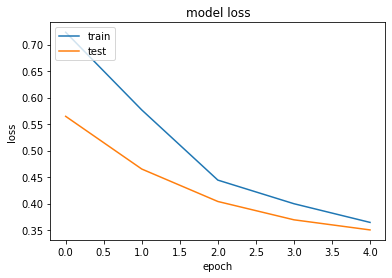

In [96]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [97]:
used_prod = (
    data.loc[lambda _df: _df["rating"] != 0, :]
    .groupby(["User_ID", "Prod_ID"])
    .agg({"rating": "first"})
    .reset_index()
)

In [98]:
all_prods_by_user = (
    data.groupby(["User_ID", "Prod_ID"]).agg({"rating": "first"}).reset_index()
)

In [99]:
def Id_for_name(name):
    return int(név_id.loc[lambda _df: _df["Név"] == name]["User_ID"])

In [114]:
# Let us get a user and see the top recommendations.
def recommend(name):
    
    user_id = Id_for_name(name)
    products_used_by_user = used_prod[used_prod.User_ID == user_id]
    products_not_used_by_user = all_prods_by_user[
        ~all_prods_by_user["Prod_ID"].isin(products_used_by_user.Prod_ID.values)
    ]["Prod_ID"]
    products_not_used_by_user = list(
        set(products_not_used_by_user).intersection(set(movie2movie_encoded.keys()))
    )
    products_not_used_by_user = [
        [movie2movie_encoded.get(x)] for x in products_not_used_by_user
    ]
    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(products_not_used_by_user), products_not_used_by_user)
    )
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-10:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(products_not_used_by_user[x][0])
        for x in top_ratings_indices
    ]

    print("Showing recommendations for user: {}".format(név_id.loc[lambda _df: _df["User_ID"] == user_id]["Név"].values))
    print("====" * 9)
    print("Products with high ratings from user")
    print("----" * 8)
    top_movies_user = (
        products_used_by_user.sort_values(by="rating", ascending=False)
        .head(5)
        .Prod_ID.values
    )
    movie_df_rows = (
        all_prods_by_user[all_prods_by_user["Prod_ID"].isin(top_movies_user)]
        .drop_duplicates()
        .loc[lambda _df: _df["User_ID"] == user_id]
    )
    for row in movie_df_rows.itertuples():
        print(
            row.Prod_ID,
            ":",
            termek_id.loc[lambda _df: _df["Prod_ID"] == row.Prod_ID]["termek"].values,
        )
        # print(row.title, ":", row.genres)

    print("----" * 8)
    print("Top 10 product recommendations")
    print("----" * 8)
    recommended_movies = all_prods_by_user[
        all_prods_by_user["Prod_ID"].isin(recommended_movie_ids)
    ].loc[lambda _df: _df["User_ID"] == user_id,:]
    for row in recommended_movies.itertuples():
        print(
            row.Prod_ID,
            ":",
            termek_id.loc[lambda _df: _df["Prod_ID"] == row.Prod_ID]["termek"].values,
        )

In [122]:
recommend("Gyenes Márk")

3/3 [==============================] - 0s 4ms/step
Showing recommendations for user: ['Gyenes Márk']
Products with high ratings from user
--------------------------------
3 : ['coca-cola (dl)']
14 : ['lays']
26 : ['gordons']
27 : ['kronenbourg blanc']
--------------------------------
Top 10 product recommendations
--------------------------------
69 : ['happy day (dl)']
70 : ['borháló irsai']
72 : ['casuino rum']
73 : ['apenta']
74 : ['bounty']
75 : ['borháló kékfrankos (dl)']
76 : ['borháló olaszrizling (dl)']
77 : ['club mate']
78 : ['tesco nagy csipsz 130g']
79 : ['tesco kis csipsz 77g']


In [104]:
nevek = data["Név"].unique()

In [105]:
ratings_dfs = []
for i in tqdm(nevek):
    user_id = Id_for_name(i)
    products_used_by_user = used_prod[used_prod.User_ID == user_id]
    products_not_used_by_user = all_prods_by_user[
        ~all_prods_by_user["Prod_ID"].isin(products_used_by_user.Prod_ID.values)
    ]["Prod_ID"]
    products_not_used_by_user = list(
        set(products_not_used_by_user).intersection(set(movie2movie_encoded.keys()))
    )
    products_not_used_by_user = [
        [movie2movie_encoded.get(x)] for x in products_not_used_by_user
    ]
    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(products_not_used_by_user), products_not_used_by_user)
    )
    ratings = model.predict(user_movie_array)

    ratings_dfs.append(
        pd.concat(
            [
                pd.DataFrame(user_movie_array).rename(
                    columns={0: "User_ID", 1: "Prod_ID"}
                ),
                pd.DataFrame(ratings).rename(columns={0: "rate_pred"}),
            ],
            axis=1,
        )
    )

  0%|          | 0/77 [00:00<?, ?it/s]

3/3 [==============================] - 0s 2ms/step


In [106]:
ratings_df = pd.concat(ratings_dfs)

In [107]:
ratings_df["User_ID"] = ratings_df["User_ID"]+1
ratings_df["Prod_ID"] = ratings_df["Prod_ID"]+1

In [108]:
top_termek_2 = (
    data.loc[lambda _df: _df["Név"].isin(top_user),:].groupby("termek")
    .agg({"Mennyiség": "sum"})
    .reset_index()
    .sort_values(by="Mennyiség", ascending=False)
    .head(5)["termek"]
    .to_list()
)

In [112]:
data.loc[lambda _df: _df["Név"].isin(top_user)].loc[lambda _df: _df["termek"].isin(top_termek_2), :].merge(
    ratings_df, on=["User_ID", "Prod_ID"], how="left"
).drop_duplicates().head()

,date,Név,termek,Mennyiség,event_count,event1,event2,event3,event4,weekday,User_ID,Prod_ID,Teljes_fogy,rating,user,product,rate_pred
0,2021-07-16,Barát Andor Kornél,uncsi,3.00,1.00,Mardekár buli,Nincs esemény,Nincs esemény,Nincs esemény,4,1,2,739.14,0.00,0,1,0.62
1,2021-07-16,Herbák Mihály,uncsi,2.00,1.00,Mardekár buli,Nincs esemény,Nincs esemény,Nincs esemény,4,3,2,721.12,0.00,2,1,0.36
2,2021-07-16,Magyar Gergely,coca-cola (dl),2.00,1.00,Mardekár buli,Nincs esemény,Nincs esemény,Nincs esemény,4,6,3,844.53,2.00,5,2,NaN
3,2021-07-16,Magyar Gergely,uncsi,6.00,1.00,Mardekár buli,Nincs esemény,Nincs esemény,Nincs esemény,4,6,2,844.53,2.00,5,1,NaN
4,2021-07-16,Pózner Vanda,coca-cola (dl),2.00,1.00,Mardekár buli,Nincs esemény,Nincs esemény,Nincs esemény,4,10,3,889.45,3.00,9,2,NaN


In [111]:
data.loc[lambda _df: _df["termek"].isin(top_termek), :].loc[lambda _df: _df["Név"].isin(top_user)].merge(
    ratings_df, on=["User_ID", "Prod_ID"], how="left"
).drop_duplicates()["Név"].nunique()

10

In [109]:
data.loc[lambda _df: _df["Név"].isin(top_user)].loc[lambda _df: _df["termek"].isin(top_termek_2), :].merge(
    ratings_df, on=["User_ID", "Prod_ID"], how="left"
).drop_duplicates().to_parquet("mldata_ratings_top20prod.parquet")